In [1]:
# ================ import env
import os,sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
sys.path.append("/home/yingmuzhi/SegPNN/sam2")    # add path
import tifffile


# ================ add device for calculate :: CUDA
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")   # actually
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [2]:
# ================ add script for plotting
np.random.seed(3)

def caculate_masks(anns):
    """
    intro:
        calculate mask number
    """
    sum = len(anns)
    print("this mask has {} hole".format(sum))
    return sum

def show_anns(anns, borders=True, plot_white_mask=False, image=None):
    if image is not None:
        plt.imshow(image)
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))    # 0 for black
    img[:, :, 3] = 0     # 1 for visiable
    for ann in sorted_anns:
        m = ann['segmentation']
        if plot_white_mask:
            color_mask = [1., 1., 1., 0.5]  
        else:
            color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

def show_anns_and_save(anns, borders=True, output_path="output.png"):
    """
    根据 anns 绘制分割结果并保存为图像文件。

    :param anns: 包含分割区域信息的列表，每个元素应包含:
                 'segmentation' (bool mask) 和 'area' 用于排序
    :param borders: 是否在蒙版边缘绘制轮廓
    :param output_path: 输出图像文件路径
    """

    if len(anns) == 0:
        print("anns 为空，不进行绘制。")
        return

    # 按面积从大到小排序，确保大面积的区域先绘制
    sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)

    # 创建 figure 和 ax
    fig, ax = plt.subplots()
    ax.set_autoscale_on(False)

    # 以最大区域尺寸初始化 RGBA 图像 (默认白色 + alpha=0)
    height, width = sorted_anns[0]['segmentation'].shape
    img = np.ones((height, width, 4), dtype=np.float32)
    img[:, :, 3] = 0  # alpha 初始化为0

    # 依次绘制蒙版
    for ann in sorted_anns:
        m = ann['segmentation']  # bool 类型或 0/1 的掩码数组
        color_mask = np.concatenate([np.random.random(3), [0.5]])  # RGBA, alpha=0.5
        img[m] = color_mask  # 将当前 mask 区域染成随机颜色

        # 如果需要边界轮廓
        if borders:
            contours, _ = cv2.findContours(m.astype(np.uint8),
                                           cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_NONE)
            # 对轮廓进行平滑
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True)
                        for contour in contours]
            # 在 img 上绘制轮廓
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    # 在画布上显示合成图像
    ax.imshow(img)
    # 可选：隐藏坐标刻度
    ax.axis('off')

    # 保存图像到指定文件
    fig.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)  # 关闭 figure，释放资源


## example

In [3]:
test_path = "/home/yingmuzhi/SegPNN/src/20250108/LSM900.jpg"
test_path = "/home/yingmuzhi/SegPNN/src/20250108/8.png"
test_path = "/home/yingmuzhi/SegPNN/src/20250213/2.jpg"
image = Image.open(test_path)

# image = Image.open('images/cars.jpg')
image = np.array(image.convert("RGB"))
image.shape

(1000, 1000, 3)

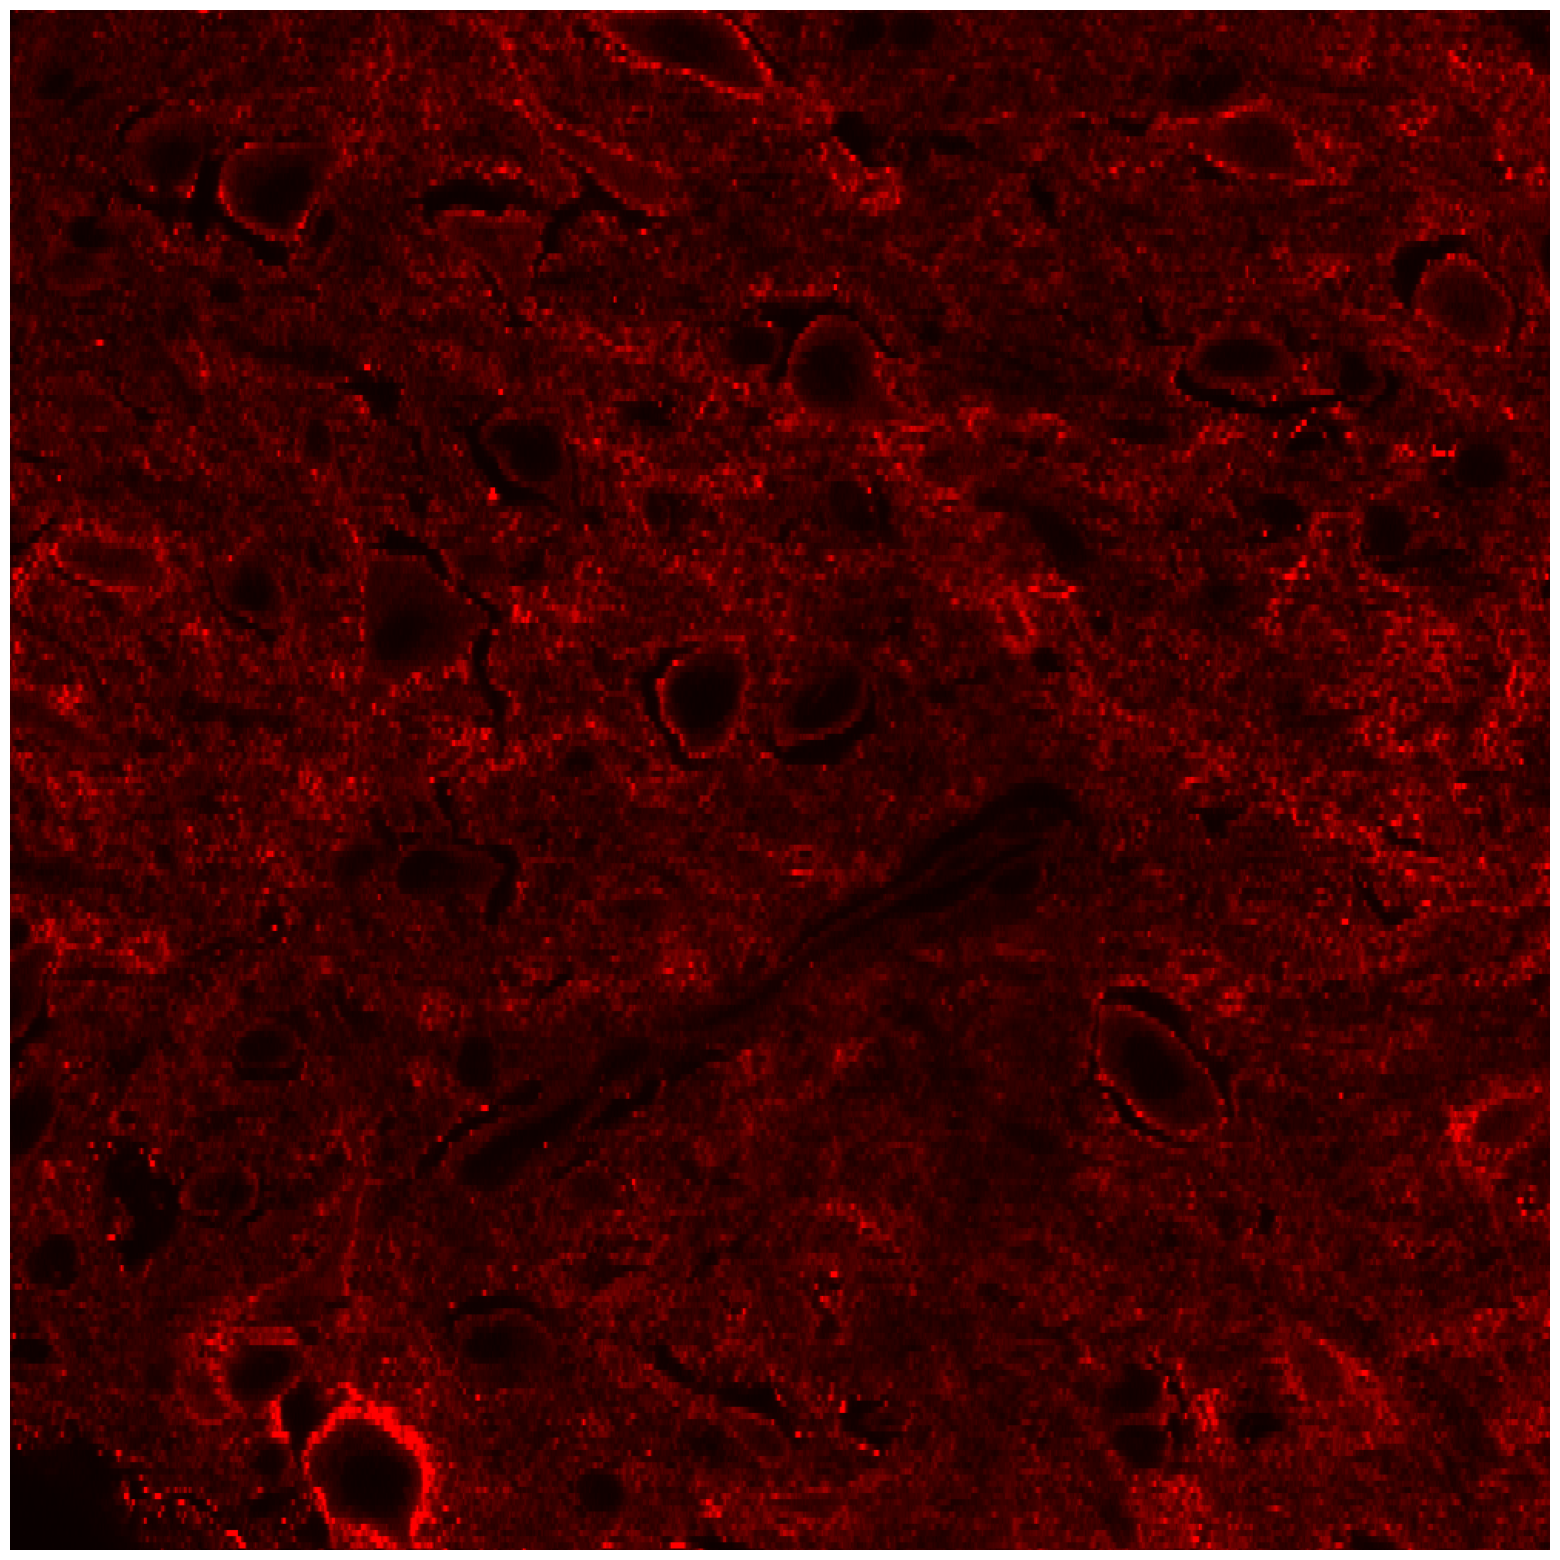

In [4]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Auto generate mask

In [5]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "/home/yingmuzhi/SegPNN/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [6]:
masks = mask_generator.generate(image)

print(image.shape,)
#print(len(masks), '\n', masks)
print(masks[0])
print(masks[1])
# print(masks[0].keys(), '\n', masks[0].values())
# dict_value = list(masks[0].values()), print(dict_value, '\n', len(dict_value[0][0]))

(1000, 1000, 3)
{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]],
      shape=(1000, 1000)), 'area': 991638, 'bbox': [0.0, 0.0, 999.0, 999.0], 'predicted_iou': 0.9921875, 'point_coords': [[203.125, 15.625]], 'stability_score': 0.9733849763870239, 'crop_box': [0.0, 0.0, 1000.0, 1000.0]}
{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]],
      shape=(1000, 1000)), 'are

In [7]:
print(len(masks))
print(masks[0].keys())

45
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


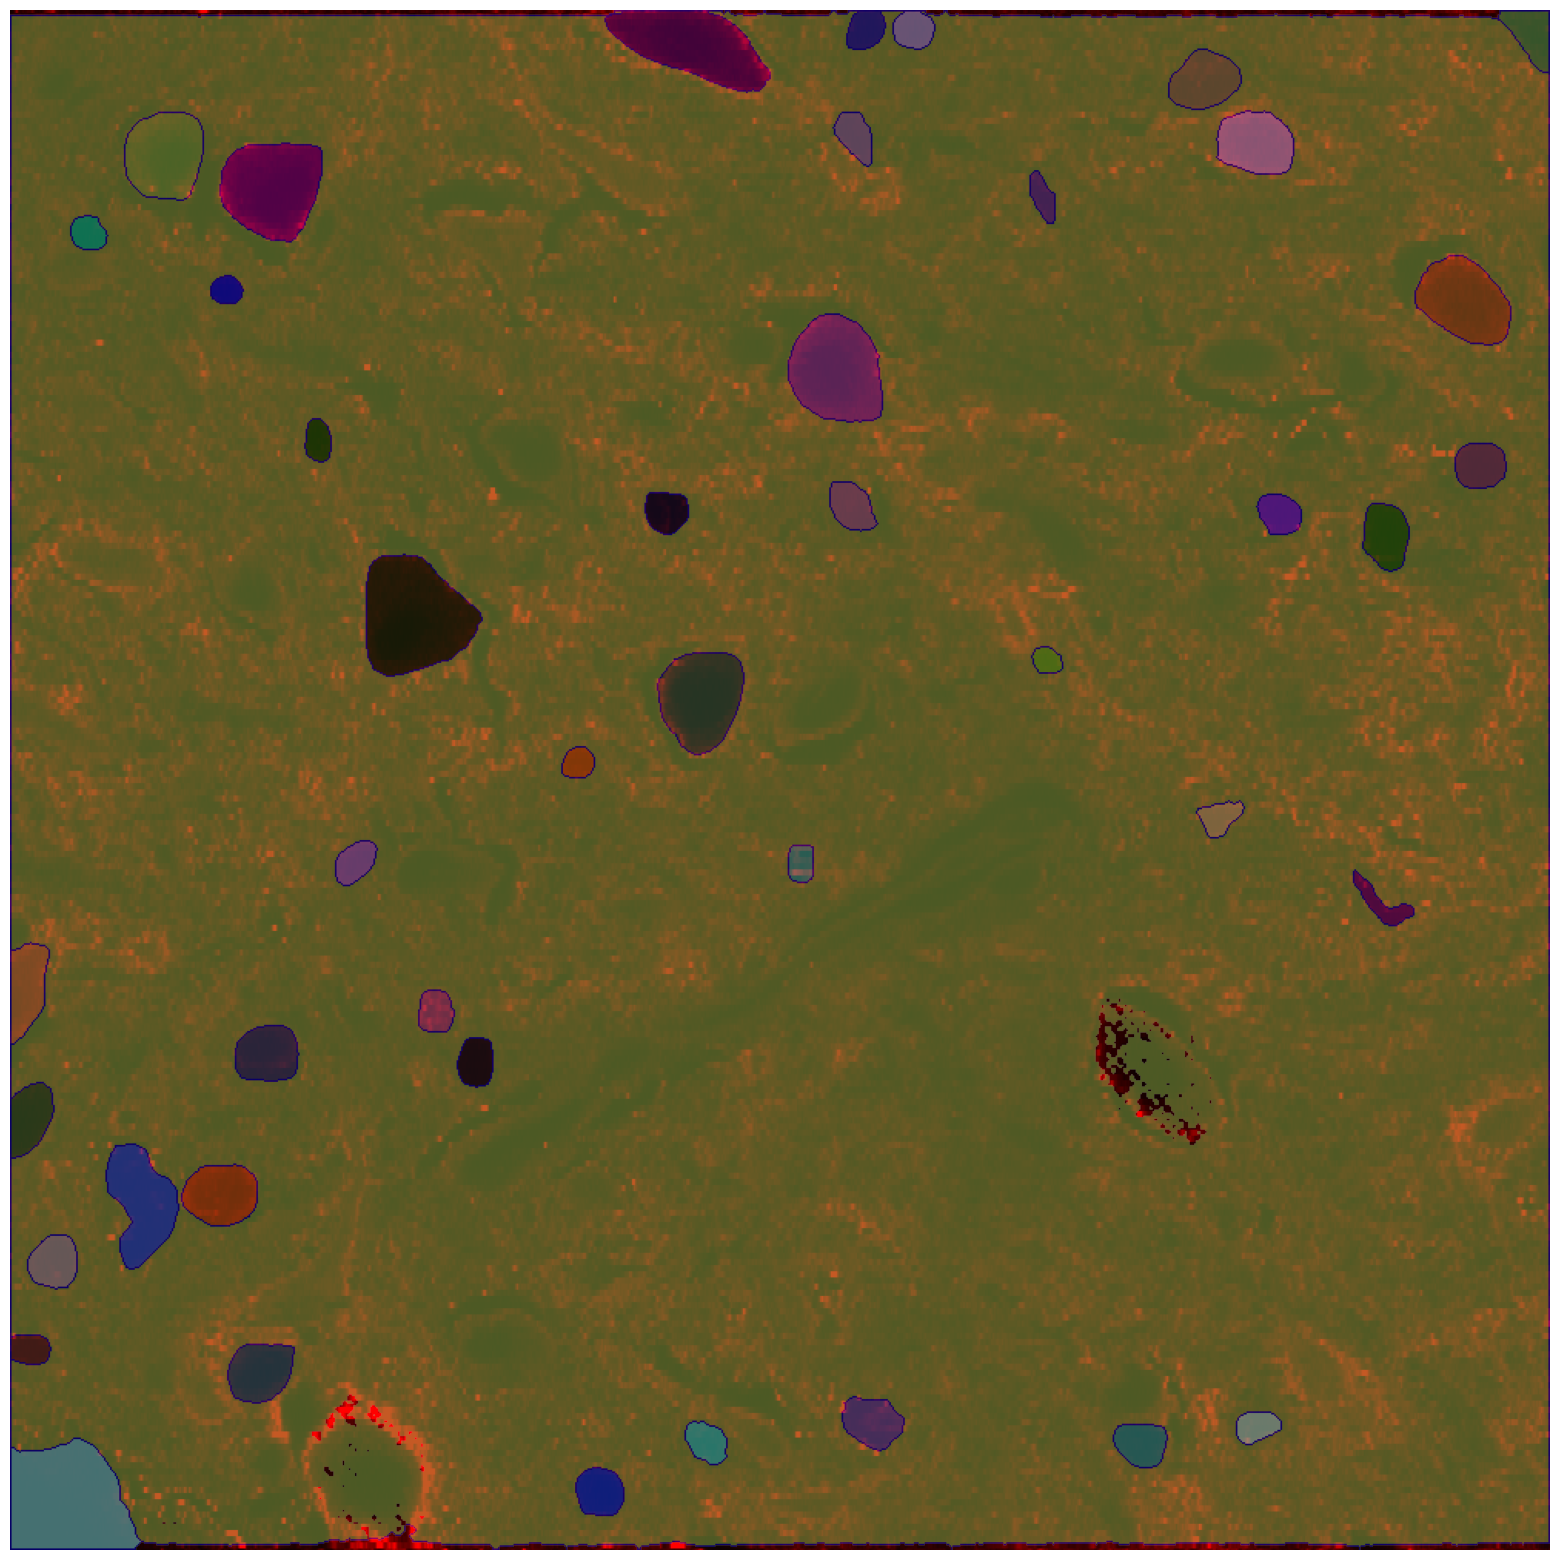

In [8]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [9]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

masks2 = mask_generator_2.generate(image)

print(len(masks2))

/home/yingmuzhi/SegPNN/sam2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/home/yingmuzhi/SegPNN/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


225


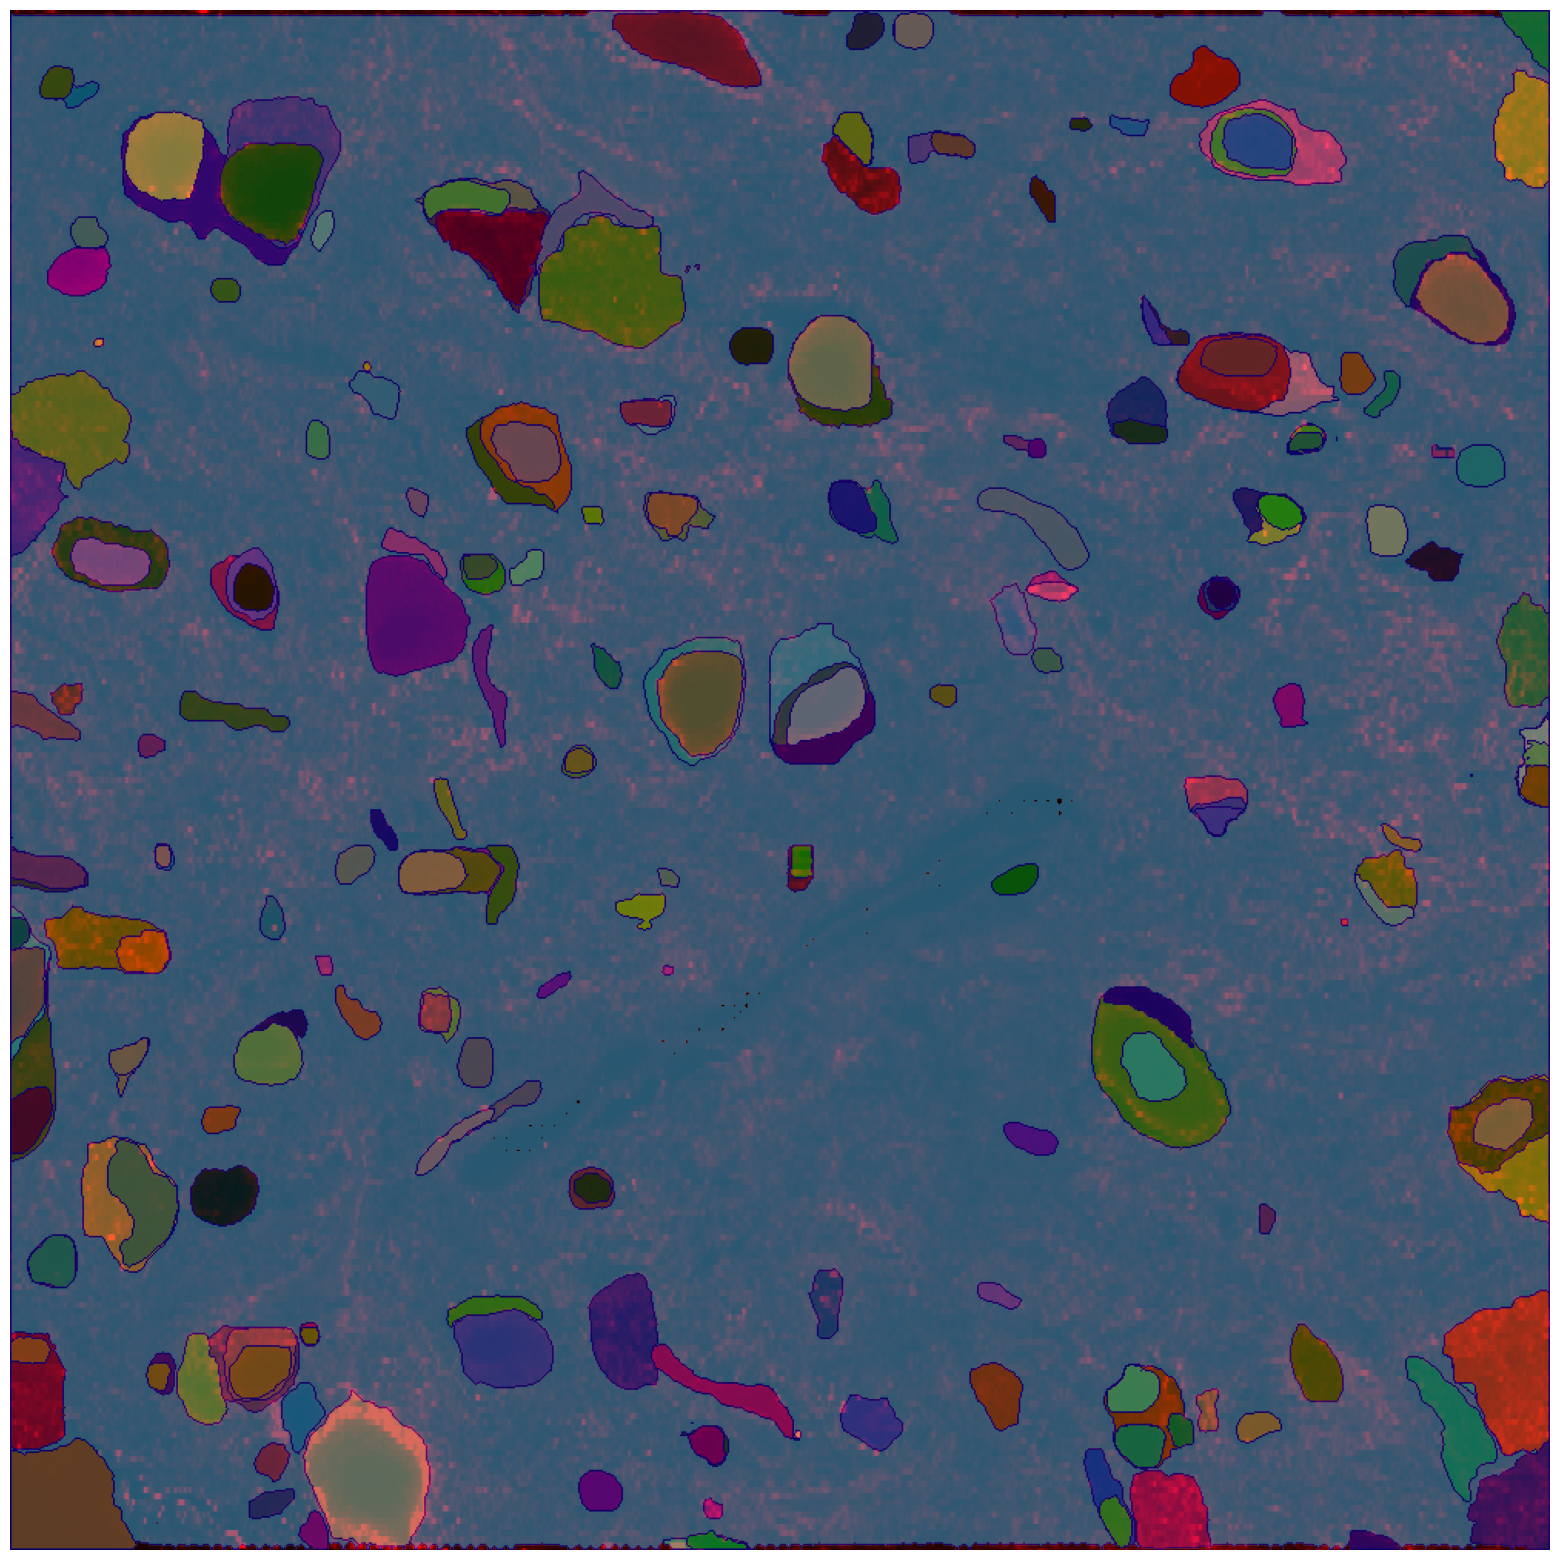

In [10]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()